# Pair trading 策略-考虑时间序列平稳性

In [2]:
import pandas as pd
import numpy as np
import tushare as ts
import seaborn
%matplotlib inline
from matplotlib import pyplot as plt
stocks_pair = ['600199', '600702']

### 前导知识

In [2]:
m = np.array([1,2,3,4,5])
n = m * 5 + 2

In [3]:
n

array([ 7, 12, 17, 22, 27])

In [4]:
slope,intercept  = np.polyfit(m, n ,1).round(2)       #np.polyfit()   unpacked
slope,intercept

(5.0, 2.0)

In [5]:
data1 = ts.get_k_data('600199', '2013-06-01', '2014-12-31')[['date','close']]
data2 = ts.get_k_data('600702', '2013-06-01', '2014-12-31')['close']
data = pd.concat([data1, data2], axis=1)


In [6]:
data.set_index('date',inplace = True)
data.columns = stocks_pair
data.head()

,600199,600702
date,,
2013-06-03,15.505,17.346
2013-06-04,14.880,16.956
2013-06-05,15.043,17.170
2013-06-06,14.668,16.868
2013-06-07,14.245,16.634


In [9]:
data.iloc[:,0]                   #index location,通过索引来获得相关数据,.loc .ix

### 1. 数据准备 & 回测准备

In [3]:
data1 = ts.get_k_data('600199', '2013-06-01', '2014-12-31')[['date','close']]

In [4]:
data2 = ts.get_k_data('600702', '2013-06-01', '2014-12-31')['close']

In [5]:
data = pd.concat([data1, data2], axis=1)

In [6]:
data.set_index('date',inplace = True)
data.columns = stocks_pair
data.head()

,600199,600702
date,,
2013-06-03,15.480,17.320
2013-06-04,14.856,16.930
2013-06-05,15.019,17.144
2013-06-06,14.645,16.843
2013-06-07,14.222,16.609


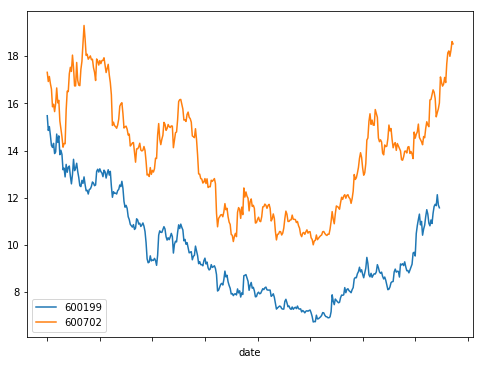

In [7]:
data.plot(figsize= (8,6))

### 2. 策略开发思路

In [8]:
data.corr()                    

,600199,600702
600199,1.000000,0.880779
600702,0.880779,1.000000


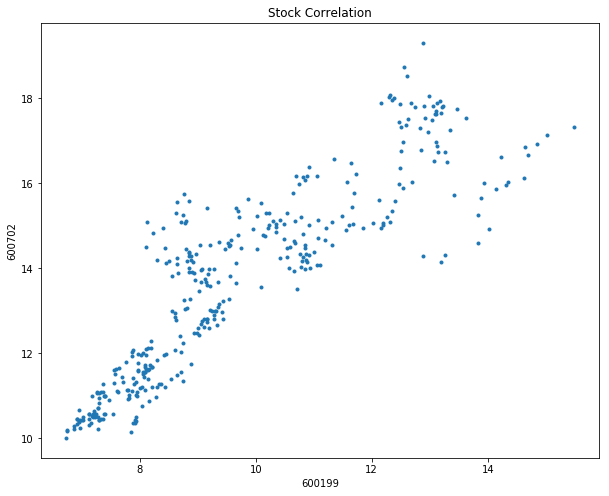

In [9]:
plt.figure(figsize =(10,8))
plt.title('Stock Correlation')
plt.plot(data['600199'], data['600702'], '.')
plt.xlabel('600199')
plt.ylabel('600702')
data.dropna(inplace = True)

In [11]:
[slope, intercept] = np.polyfit(data.iloc[:,0], data.iloc[:,1], 1).round(2)      
slope,intercept

(0.97, 4.28)

In [12]:
data['spread'] = data.iloc[:,1] - data.iloc[:,0]*slope - intercept   
# 误差spread=y-4.29-0.97x
# y：199   x:702

In [13]:
data.head()

,600199,600702,spread
date,,,
2013-06-03,15.480,17.320,-1.97560
2013-06-04,14.856,16.930,-1.76032
2013-06-05,15.019,17.144,-1.70443
2013-06-06,14.645,16.843,-1.64265
2013-06-07,14.222,16.609,-1.46634


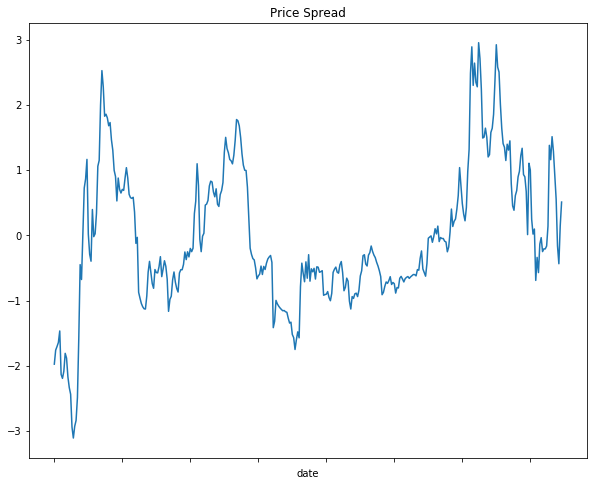

In [14]:
data['spread'].plot(figsize = (10,8),title = 'Price Spread')

In [16]:
data['zscore'] = (data['spread'] - data['spread'].mean())/data['spread'].std()   #标准化，  .std()方差 

In [17]:
data.head()

,600199,600702,spread,zscore
date,,,,
2013-06-03,15.480,17.320,-1.97560,-1.803530
2013-06-04,14.856,16.930,-1.76032,-1.604447
2013-06-05,15.019,17.144,-1.70443,-1.552762
2013-06-06,14.645,16.843,-1.64265,-1.495630
2013-06-07,14.222,16.609,-1.46634,-1.332586


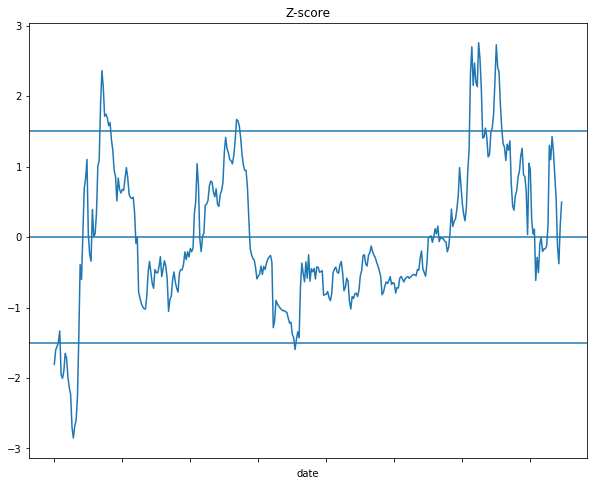

In [18]:
data['zscore'].plot(figsize = (10,8),title = 'Z-score')
plt.axhline(1.5)
plt.axhline(0)
plt.axhline(-1.5)

#### 产生交易信号

In [19]:
data['position_1'] = np.where(data['zscore'] > 1.5, 1, np.nan)
data['position_1'] = np.where(data['zscore'] < -1.5, -1, data['position_1'])
data['position_1'] = np.where(abs(data['zscore']) < 0.5, 0, data['position_1'])

In [20]:
data['position_1'] = data['position_1'].fillna(method = 'ffill')

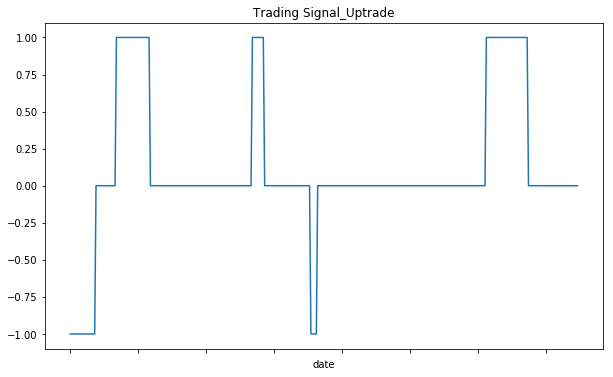

In [21]:
data['position_1'].plot(ylim=[-1.1, 1.1], figsize=(10, 6),title = 'Trading Signal_Uptrade')

In [22]:
data['position_2'] = -np.sign(data['position_1'])

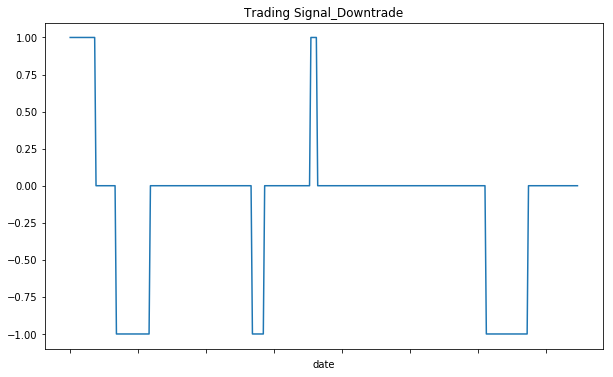

In [23]:
data['position_2'].plot(ylim=[-1.1, 1.1], figsize=(10, 6),title = 'Trading Signal_Downtrade')

### 3. 计算策略年化收益并可视化

In [24]:
data['returns_1'] = np.log(data['600199'] / data['600199'].shift(1))

In [25]:
data['returns_2'] = np.log(data['600702'] / data['600702'].shift(1))

In [27]:
data['strategy'] = 0.5*(data['position_1'].shift(1) * data['returns_1'])
                  +0.5*(data['position_2'].shift(1) * data['returns_2'])

date
2013-06-03         NaN
2013-06-04   -0.011387
2013-06-05    0.006281
2013-06-06   -0.008857
2013-06-07   -0.006995
2013-06-13   -0.023104
2013-06-14    0.003362
2013-06-17   -0.009836
2013-06-18    0.010774
2013-06-19    0.020276
2013-06-20   -0.019370
2013-06-21    0.003327
2013-06-24   -0.027916
2013-06-25   -0.010666
2013-06-26   -0.011515
2013-06-27   -0.015589
2013-06-28    0.005484
2013-07-01   -0.000350
2013-07-02    0.047712
2013-07-03    0.024754
2013-07-04    0.000000
2013-07-05   -0.000000
2013-07-08   -0.000000
2013-07-09    0.000000
2013-07-10   -0.000000
2013-07-11    0.000000
2013-07-12    0.000000
2013-07-15   -0.000000
2013-07-16   -0.000000
2013-07-17    0.000000
                ...   
2014-11-20   -0.000000
2014-11-21    0.000000
2014-11-24   -0.000000
2014-11-25    0.000000
2014-11-26    0.000000
2014-11-27   -0.000000
2014-11-28    0.000000
2014-12-01   -0.000000
2014-12-02   -0.000000
2014-12-03   -0.000000
2014-12-04    0.000000
2014-12-05    0.000000
2014-1

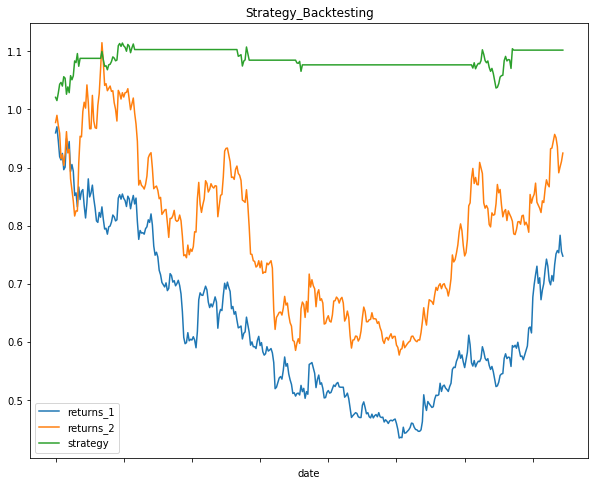

In [29]:
data[['returns_1','returns_2','strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 8),title = 'Strategy_Backtesting')

**策略的思考**

1. 对多只ETF进行配对交易，是很多实盘量化基金的交易策略；

**策略的风险和问题：**

1. Spread不回归的风险，当市场结构发生重大改变时，用过去历史回归出来的Spread会发生不回归的重大风险；

2. 中国市场做空受到限制，策略中有部分做空的收益是无法获得的；

3. 回归系数需要Rebalancing（系数要改变）；

4. 策略没有考虑交易成本和其他成本；

声明：本资料仅限内部研究和交流使用，切勿外传。